have a look at the readme file!

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# classes

In [20]:
class Agent:
    """
    Represents an agent in an election.
    """
    id: int
    costs: dict  # costs[alternative] = cost
    preference: int
    ordinal_preferences: list

    def __init__(self, id, costs=None, ordinal_preferences=None, alpha=None):
        """
        Initialize an agent with sevreal options for initialization:
        1. given costs, ordinal_preferences are calculated from the costs. cost here means how much the agent values each alternative (lower is better) 
        2. given alpha and ordinal_preferences, costs are calculated such that the ratio between the lowest cost and the second-lowest cost is alpha at most to generate an alpha-decisive agent.
        3. otherwise an "empty" agent is created to be used later.
        :param id: the id of the agent
        :param costs: Optional. A dictionary of alternatives and their costs.
        :param ordinal_preferences: Optional. A list of alternatives in the order of the agent's preference.
        :param alpha: Optional. The alpha value for the alpha-decisive agent.
        """
        self.id = id
        self.costs=dict()
        if costs is not None:
            self.costs = costs
            self.ordinal_preferences = sorted(costs, key=costs.get)
            ordinal_preferences = self.ordinal_preferences
            self.preference = self.ordinal_preferences[0]
        if alpha is not None:
            self.ordinal_preferences = ordinal_preferences
            self.preference = ordinal_preferences[0]
            for i in range(len(ordinal_preferences)):
                self.costs[ordinal_preferences[i]] = 0
            self.costs[ordinal_preferences[1]] = 2 * np.random.uniform(0.0, 2.0)
            self.costs = self.possible_costs(alpha)

    def possible_costs(self,alpha):
        """
        randomly generates costs for the agent such that the original preference is being preserved (the lowest cost)
        and the ratio between the lowest cost and the second-lowest cost is alpha at most
        :param alpha: A float value representing alpha.
        :return: A dictionary of fictitious costs.
        """
        fictitious_costs = {}
        alternatives = self.ordinal_preferences.copy()
        second_alternative = alternatives[1]
        fictitious_costs[second_alternative] = self.costs[second_alternative]
        alternatives.remove(second_alternative)
        alpha_preserving_cost = self.costs[second_alternative] * alpha
        fictitious_costs[self.preference] = np.random.uniform(0,alpha_preserving_cost)
        alternatives.remove(self.preference)
        # randomly assign costs to the remaining alternatives while preserving the order
        costs = sorted([np.random.uniform(fictitious_costs[second_alternative],2) for _ in range(len(alternatives))])
        for i in range(len(alternatives)):
            fictitious_costs[alternatives[i]] = costs[i]
        return fictitious_costs
    
class Election:
    """
    Represents an election with candidates.
    """
    candidates: list
    alternatives: list
    alpha: float

    def __init__(self, candidates):
        """
        Initialize an election with candidates.
        :param candidates: A list of candidates.
        """
        self.candidates = candidates
        self.alternatives = candidates # alternatives are the candidates themselves

    def get_best_alpha(self, agents):
        """
        Calculate the best/lowest alpha for the election given the agents.
        :param agents: A list of agents.
        :return: The lowest possible alpha value as a float.
        """
        alpha = 0
        for agent in agents:
            costs = agent.costs
            costs = sorted(costs.items(), key=lambda x: x[1])
            alpha = max(alpha, costs[0][1] / costs[1][1])
        return alpha

## class functions

In [21]:
def random_election(num_agents, num_candidates):
    """
    generates an election with num_candidates candidates ajg num_agents agents that have random ordinal preferences and corresponding random costs
    
    :param num_agents: Number of voters in the election.
    :param num_candidates: Number of candidates in the election.
    :return: A tuple containing the election object and a list of voters.
    """
    agents = []
    candidates = list(range(num_candidates))
    election = Election(candidates)
    for i in range(num_agents):
        costs = {}
        for alternative in election.alternatives:
            costs[alternative] = np.random.rand()
        agents.append(Agent(i, costs))
        
    # find the best alpha for the election
    alpha = max(sorted(agent.costs.items(), key=lambda x: x[1])[0][1] / sorted(agent.costs.items(), key=lambda x: x[1])[1][1] for agent in agents)
    election.alpha = alpha
    
    return election, agents

def random_election_with_alpha(num_agents, num_candidates, alpha):
    """
    generates an alpha-decisive election with num_candidates candidates and num_agents agents that have random ordinal preferences and corresponding random costs such that the ratio between the lowest cost and the second-lowest cost is alpha at most
    :param num_agents: Number of voters in the election.
    :param num_candidates: Number of candidates in the election.
    :param alpha: The maximum ratio between the lowest cost and the second-lowest cost.
    :return: A tuple containing the election object and a list of voters.
    """
    agents = []
    candidates = list(range(num_candidates))
    election = Election(candidates)
    election.alpha = alpha
    for i in range(num_agents):
        preference_order= list(np.random.permutation(election.alternatives))
        agents.append(Agent(i, ordinal_preferences=preference_order, alpha=alpha))
        
    return election, agents

# social choice functions
1. Plurality: This function returns the alternative that is most preferred by the highest number of agents.  
2. Borda: This function assigns points to alternatives based on their ranking in each agent's preference order. The alternative with the highest total points is the winner. 
3. Random Dictatorship: This function randomly selects one agent and returns their most preferred alternative.  
4. Alpha Generalized Proportional to Squares (alphaGPtS): This function is an implementation of a probabilistic social choice function only for two alternatives. It returns a dictionary with the probability of each alternative being chosen.

Each of these functions takes a profile of agents as input (alphaGPtS need additionally alpha as input), and returns a dictionary mapping each winner to the probability that the function chooses that winner.


In [22]:
# Deterministic social choice functions

def plurality(profile, alpha=None):
    """
    Implementation of the plurality social choice function
    :param profile: list of agents
    :param alpha: 
    :return: dict {winner_id : probability that f choose winner} 
    """
    candidates = defaultdict(int)
    for agent in profile:
        candidates[agent.preference] += 1
    candidates = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    winner = {candidates[0][0]: 1}
    return winner


def borda(profile, alpha=None):
    """
    Implementation of the borda social choice function
    :param profile: list of agents
    :param alpha: 
    :return: dict {winner_id : probability that f choose winner} 
    """
    n = len(profile[0].ordinal_preferences)
    candidates = defaultdict(int)
    for agent in profile:
        for i in range(n):
            candidates[agent.ordinal_preferences[i]] += n - i
    candidates = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    winner = {candidates[0][0]: 1}
    return winner

## Random social choice functions
def random_dictatorship(profile, alpha=None):
    """
    Implementation of the random_dictatorship social choice function
    :param profile: list of agents
    :param alpha: 
    :return: dict {winner_id : probability that f choose winner} 
    """
    n = len(profile)
    preferences = defaultdict(int)
    for agent in profile:
        preferences[agent.preference] += 1
    for preference in preferences.keys():
        preferences[preference] /= n
    return preferences

this is implementation of the social choice function for the alpha-decisive election, however it has major problem as I suspect that there is a mistake in the paper as the described function appear to be wrong, as it can return negative probabilities. 
an easy example to see for yourself would be $|Y^*|=2,|X^*|=8,\alpha=0.5$, which will get $p(Y)=\frac{-1}{43}\lt0$ and $p(X)=\frac{44}{43}\gt1$ which are obviously not probabilities.

here is the formula as it appear in the paper for you convince:
$$p(Y) = \frac{(1 + \alpha)|Y^*|^2 - (1 - \alpha)|X^*||Y^*|}{(1 + \alpha)(|X^*|^2 + |Y^*|^2) - 2(1 - \alpha)|X^*||Y^*|}$$

In [ ]:

# alpha Generalized Proportional to Squares from page 14 in the paper
def alpha_Generalized_Proportional_to_Squares(profile, alpha):  # currently implemented only for m=2
    """
    :param profile: list of agents
    :param alpha: alpha value of alpha-decisive election
    :return: dict {winner_id : probability that f choose winner} 
    """
    m = len(profile[0].ordinal_preferences)
    if m != 2:
        raise ValueError("alphaGPtS Currently implemented only for m=2")
    preferences = defaultdict(int)
    X = profile[0].ordinal_preferences[0]
    X_votes = len([agent for agent in profile if agent.preference == X])
    Y = profile[0].ordinal_preferences[1]
    Y_votes = len([agent for agent in profile if agent.preference == Y])

    preferences[Y] = proportional_to_squares(X_votes, Y_votes, alpha)
    preferences[X] = proportional_to_squares(Y_votes, X_votes, alpha)

    return preferences

def proportional_to_squares(x, y, alpha):
    result=((((1 + alpha) * y ** 2) - ((1 - alpha) * x * y)) /
            (((1 + alpha) * (x ** 2 + y ** 2)) - (2 * (1 - alpha) * x * y)))
    if result>1: # the function is wrong, this was an attempt to cap the values, but it is not enough.
        return 1
    if result<0:
        return 0
    return result
# Alias for ease of use in the code
alphaGPtS = alpha_Generalized_Proportional_to_Squares

skeleton implementation of Algorithm 1: Optimal randomized mechanism for the α-decisive, 1-Euclidean space

need to implment the utility functions:
1. 1-Euclidean ordering of agents
2. 1-Euclidean ordering of alternatives

both from paper "Recognizing 1-euclidean preferences: An alternative approach"
3. find_median_agent
4. size(X,Y) (function that find the size of the set of agents that prefer X to Y)


intuition for the algorithm:
using the preference profile we can determine the ordering of the agents on the line (hence 1-Euclidean requirment)
and the unique ordering of the alternatives that are between the top preference of the first agent and the top preference
of the last agent. While this information is not enough to find the optimal alternative we can use
this information to significantly reduce the set of alternatives that might be optimal, Then we use $\alpha$-generalized proportional to squares (already implmented) on this smaller ($m\rightarrow 3$) set of alternatives to achieve a better distortion bound.

this algorithm achieve worst-case distortion of $1+\alpha$ at most. 

In [23]:
def alpha_GPtS_Euclidean(profile, alpha):
    ordered_agents, ordered_alternatives = euclidean_ordering(profile)
    i_tag= find_median_agent(ordered_agents)
    X=ordered_agents[i_tag].preference
    X_i=ordered_alternatives.iloc(X)
    Y=ordered_agents[X_i-1].preference
    Z=ordered_agents[X_i+1].preference
    YX=size(Y,X,profile)
    XY=size(X,Y,profile)
    ZX=size(Z,X,profile)
    XZ=size(X,Z,profile)
    preferences = defaultdict(int)
    if YX<ZX:
        preferences[Z]=proportional_to_squares(ZX,XZ,alpha)
        preferences[X]=proportional_to_squares(XZ,ZX,alpha)
    elif YX>ZX:
        preferences[Y]=proportional_to_squares(YX,XY,alpha)
        preferences[X]=proportional_to_squares(XY,YX,alpha)
    else:
        preferences[X]=1
        
    return preferences
    
    
def euclidean_ordering(profile): # this is the hard part.
    """
    :param profile: list of agents
    :return: 1-Euclidean ordering of agents and alternatives
    """
    pass
def find_median_agent(ordered_agents):
    """
    :param ordered_agents: 1-Euclidean ordering of agents
    :return: index of the median agent
    """
    pass
def size(X,Y,profile):
    """
    :param X: alternative
    :param Y: alternative
    :param profile: list of agents
    :return: size of the set of agents that prefer X to Y
    """
    pass

# objectives functions
1. Sum of Social Costs (sum_SC): This function calculates the sum of the costs of the chosen alternative for all agents. The cost here is how much the agent values each alternative (lower is better).  
2. Median of Social Costs (med): This function calculates the median of the costs of the chosen alternative for all agents. This function is less sensitive to outliers than the sum_SC function.

Each of these functions takes an alternative and a profile of agents as input, and returns the total or median cost associated with the chosen alternative.

probabilistic_cost is a function that calculates the expected cost of a probabilistic social choice function given a profile of agents and an objective function. its implementation enable us to treat all objective functions the same way

In [24]:
def sum_SC(x, d):
    """
    :param x: chosen alternative
    :param d: list of agents
    :return: sum of costs
    """
    return sum([agent.costs[x] for agent in d])


def med(x, d):
    """
    :param x: chosen alternative
    :param d: list of agents
    :return: median of costs
    """
    return np.median([agent.costs[x] for agent in d])

def probabilistic_cost(f, profile, objective, alpha):
    """
    :param f: probabilistic social choice function
    :param profile: list of agents
    :param objective: objective function
    :return: expected cost
    """
    sum = 0
    alternatives = f(profile, alpha)
    for alternative in alternatives.keys():
        p = alternatives[alternative]
        sum += p * objective(alternative, profile)
    return sum

distortion is defined as follows:
$$dist_{\Sigma}(f,\sigma)=\frac{sup_{d\in\rho^{-1}(\sigma)}SC(f(\sigma),d)}{min_{X\in M}SC(X,d)}$$
here is a small intuition to understand how the "worst_cost" for the sum_SC distortion in the code (in the formula it is defined as $sup_{d\in\rho^{-1}$) was derived:
suppose that there two groups of people, the first group has very strong **dis**-preference for candidate $X$ and the second group has very slight preference for candidate $X$.

if $X$ wins the people who have strong dis-preference for $X$ are very unhappy and the people who had slight preference for $X$ are only slightly happy.

in comparison, if $Y!=X$ wins the people who have strong dis-preference for $X$ are very happy and the people who had slight preference for $X$  are only slightly disappointed.

full proof can be found in the 4th theorem in this paper: [Approximating optimal social choice under metric preferences](https://www.sciencedirect.com/science/article/pii/S0004370218304569#se0080)

In [25]:
def distortion(f, profile, objective, election):
    """
    Calculates the distortion of a social choice function.
    
    :param f: Social choice function.
    :param profile: A list of agents participating in the election.
    :param objective: Objective function to calculate the social cost.
    :param election: Election object.
    :return: The distortion for the given social choice function.
    """
    alpha = election.alpha
    winners = f(profile, alpha)
    epsilon = (1.0 - alpha) / (alpha + 1.0)
    worst_distortion = 0
    for winner in winners.keys():  # winners is a dict {winner_id : probability that f choose winner}
        worst_profile = []
        for agent in profile:
            if agent.preference == winner:  # maximally indecisive reward for winner
                worst_costs = {candidate: 1 + epsilon for candidate in election.candidates}
                worst_costs[winner] = 1 - epsilon
            else:  # maximally decisive negative cost for the winner for the rest
                worst_costs = {candidate: 0.0 for candidate in election.candidates}
                worst_costs[winner] = 2.0
            fictitious_agent = Agent(agent.id, worst_costs)
            worst_profile.append(fictitious_agent)
            
        realized_worst_cost = probabilistic_cost(f, worst_profile, objective, alpha)
        optimal_cost = min(objective(alternative, worst_profile) for alternative in election.alternatives)
        
        if optimal_cost==0:
            if realized_worst_cost==0:
                worst_distortion = max(worst_distortion, 1)
            else:
                worst_distortion = max(worst_distortion, np.inf)
        else:
            worst_distortion = max(worst_distortion, realized_worst_cost / optimal_cost)
            
    return worst_distortion

# visualization

In [26]:
def plot_histogram(data, axis, title, upper_bound,lower_bound=None):
    if lower_bound is None:
        lower_bound=upper_bound

    sns.histplot(data, ax=axis)
    axis.axvline(upper_bound, color='r', linestyle='dashed', linewidth=1)
    axis.axvline(lower_bound, color='r', linestyle='dashed', linewidth=1)
    axis.set_title(title)

# main 

In [27]:
def simulate_elections(num_agents=20, num_candidates=2, alpha=0.5, verbose=False):
    """
    Simulates an election with given parameters and calculates distortions for different social choice functions.

    Parameters:
    num_agents (int): The number of agents participating in the election.
    num_candidates (int): The number of candidates in the election.
    alpha (float): The alpha value for the alpha-decisive election.
    verbose (bool): If True, prints additional information about the election and agents.
    return: A list of distortions for different social choice functions.
    """
    election, agents = random_election_with_alpha(num_agents, num_candidates, alpha)
    distortions_SC = []
    objectives=[random_dictatorship, plurality, borda]
    if num_candidates==2:
        objectives+= [alphaGPtS]
    for f in objectives:
        distortions_SC.append(distortion(f,agents,sum_SC,election))
    if verbose:
        print("the agents are: ")
        for agent in agents:
            print(agent.ordinal_preferences)
        print("the election is: ")
        print(election.alternatives)
        alpha = election.get_best_alpha(agents)
        print("the alpha for the election is: ", alpha)

    return distortions_SC

In [28]:
def part_1(iterations=100,alpha=0.5,num_agents=10,num_candidates=2):
    sum_SC_distortions = []
    for _ in iterations:
        distortions_SC = simulate_elections(num_agents, num_candidates, alpha)
        sum_SC_distortions.append(distortions_SC)
    sum_SC_distortions = np.round(np.array(sum_SC_distortions),2)
    
    # worst-case bounds
    deterministic_wc_bound = 2 * num_candidates - 1 # deterministic_worst_case_bound
    random_dictatorship_wc_upper_bound = 2 + alpha - 2 / num_agents # random_dictatorship_worst_case_upper_bound
    random_dictatorship_wc_lower_bound = 1 + alpha # random_dictatorship_worst_case_lower_bound

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    plot_histogram(sum_SC_distortions[:, 0], axs[0], "sum_SC distortion histogram for random dictatorship", random_dictatorship_wc_upper_bound,random_dictatorship_wc_lower_bound)
    plot_histogram(sum_SC_distortions[:, 1], axs[1], "sum_SC distortion histogram for plurality", deterministic_wc_bound)
    plot_histogram(sum_SC_distortions[:, 2], axs[2], "sum_SC distortion histogram for borda", deterministic_wc_bound)

    plt.tight_layout()  # Adjust the padding between and around the subplots
    plt.show()

# part 2

this "static_example" show a simple pet case with "worst-profile" that achieve the "worst-case distortion" discussed in the paper

In [29]:
def static_example():
    num_agents = 2
    winners_n = 1
    num_candidates = 2
    alpha = 0.5
    epsilon = (1.0 - alpha) / (alpha + 1.0)
    winner_voters_costs = {0: 1.0+epsilon, 1: 1.0-epsilon}
    loser_voters_costs = {0: 0.0, 1: 2.0}
    agents_costs = []
    for i in range(winners_n):
        agents_costs.append(winner_voters_costs.copy())
    for i in range(num_agents - winners_n):
        agents_costs.append(loser_voters_costs.copy())
    agents = [Agent(i, costs) for i, costs in enumerate(agents_costs)]
    election = Election(list(range(num_candidates)))
    election.alpha = alpha
    distortions_SC = []
    for f in [random_dictatorship, plurality, borda, alphaGPtS]:
        dist = distortion(f, agents, sum_SC, election)
        distortions_SC.append(round(dist,2))
    print(distortions_SC)
static_example()

[1.5, 2.0, 2.0, 1.5]


proof for $\alpha$-decisive worst-case bounds of determnistic social choice functions:

follow from the proof of the general (1-decisive) case, 

Suppose there are only two alternatives X and W. Half of the agents prefer X over W, and the other half prefer W over X. Suppose without loss of generality that the given voting rule picks W as one of the winners. Consider then the following metric. All agents who prefer X to W are located exactly at X, i.e. $d(i,X)=X$ and $d(i,W)=2$ all n/2 agents who prefer W are approximately halfway between X and W i.e.
$d(i,X)=1+\epsilon$ and $d(i,W)=1-\epsilon$ for some small $\epsilon>0$.Then $SC_{\Sigma}(X,d)=\Sigma_{i\in N}d(i,X)=(1+\epsilon)\cdot \frac{n}{2}$ and $SC_\Sigma(W,d)=\Sigma_{i\in N}d(i,W)=2\cdot \frac{n}{2}+(1-\epsilon)\cdot\frac{n}{2}$ for $1\leq\alpha\geq0$ as  $\epsilon$ approaches $\frac{1-\alpha}{1+\alpha}$$^\dagger$ the distortion approaches $1+2\cdot\alpha$ 

$^\dagger$ $_{this\ number\ make\ the\ ratio\ between\ the\ first\ and\ second\ choice\ equal\ to\ \alpha}$.

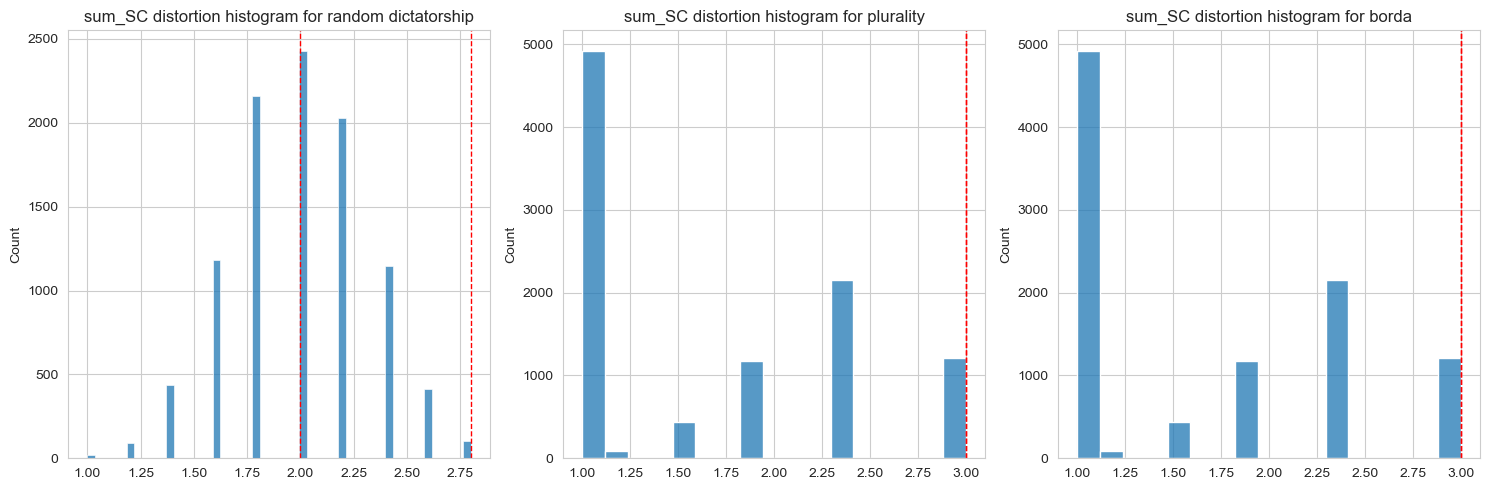

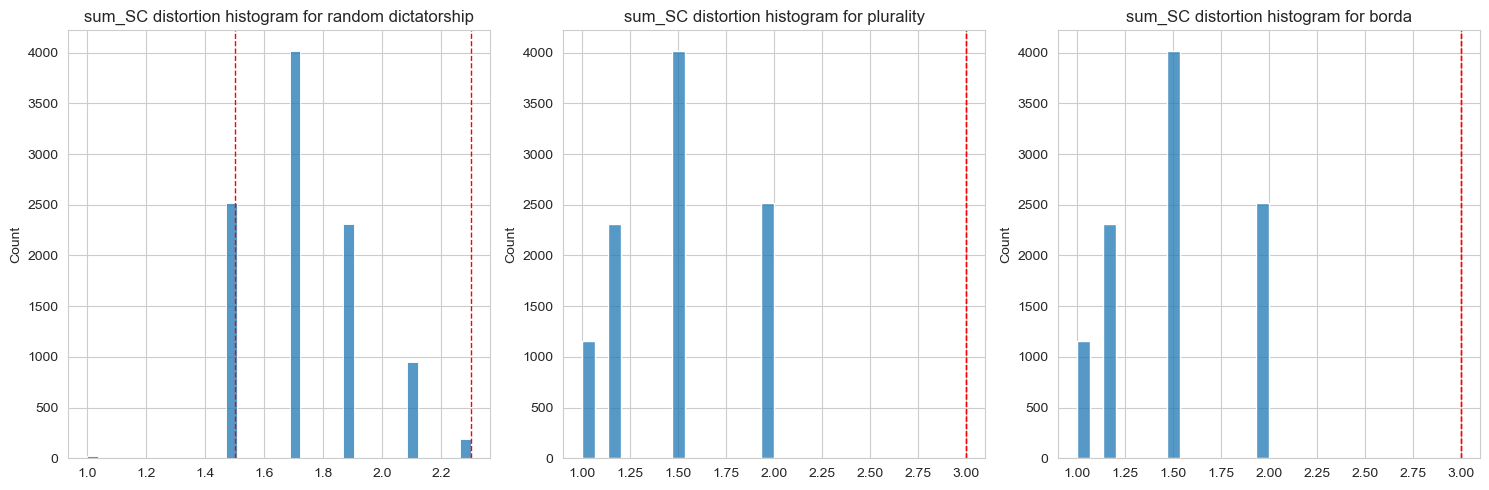

In [30]:
iterations = range(10000)
alpha = 1.0
num_agents = 10
num_candidates = 2
part_1(iterations, alpha, num_agents, num_candidates)
alpha = 0.5
part_1(iterations, alpha, num_agents, num_candidates)

In [31]:
def part_2(iterations=100,alpha=0.5,num_agents=10,num_candidates=2,no_GPts=False):
    sum_SC_distortions = []
    for _ in iterations:
        distortions_SC = simulate_elections(num_agents, num_candidates, alpha)
        sum_SC_distortions.append(distortions_SC)
    sum_SC_distortions = np.round(np.array(sum_SC_distortions),2)
    
    # worst-case bounds
    deterministic_wc_bound = 1+2*alpha # deterministic_worst_case_bound
    random_dictatorship_wc_upper_bound = 2 + alpha - 2 / num_agents # random_dictatorship_worst_case_upper_bound
    random_dictatorship_wc_lower_bound = 1 + alpha # random_dictatorship_worst_case_lower_bound
    alphaGPtS_wc_bound = 1 + alpha # alphaGPtS_worst_case_bound
    if num_candidates>2 or no_GPts:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        plot_histogram(sum_SC_distortions[:, 0], axs[0], "sum_SC distortion histogram for random dictatorship", random_dictatorship_wc_upper_bound,random_dictatorship_wc_lower_bound)
        plot_histogram(sum_SC_distortions[:, 1], axs[1], "sum_SC distortion histogram for plurality", deterministic_wc_bound)
        plot_histogram(sum_SC_distortions[:, 2], axs[2], "sum_SC distortion histogram for borda", deterministic_wc_bound)
    else:
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        plot_histogram(sum_SC_distortions[:, 0], axs[0, 0], "sum_SC distortion histogram for random dictatorship", random_dictatorship_wc_upper_bound,random_dictatorship_wc_lower_bound)
        plot_histogram(sum_SC_distortions[:, 1], axs[0, 1], "sum_SC distortion histogram for plurality", deterministic_wc_bound)
        plot_histogram(sum_SC_distortions[:, 2], axs[0, 2], "sum_SC distortion histogram for borda", deterministic_wc_bound)
        plot_histogram(sum_SC_distortions[:, 2], axs[1, 1], "sum_SC distortion histogram for alpha Generalized Proportional to Squares", alphaGPtS_wc_bound)

    plt.tight_layout()  # Adjust the padding between and around the subplots
    plt.show()

# investagtion 

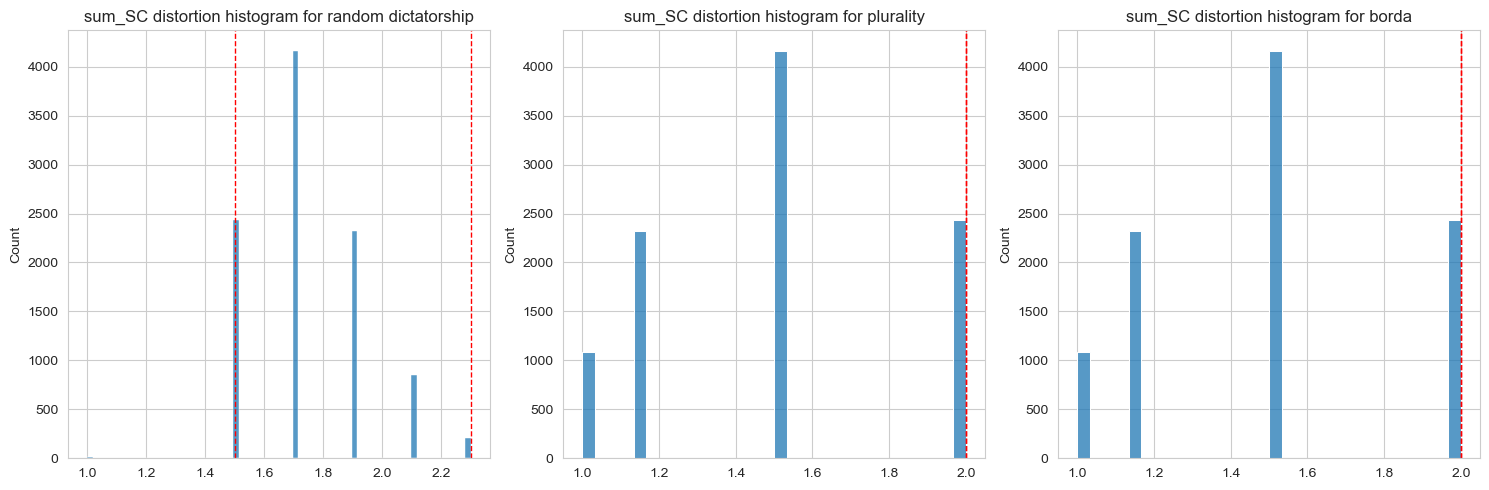

In [32]:
# this is the same graph as before after applying the new boundaries for the deterministic social function taking into consideration  alpha-decisiveness 
iterations = range(10000)
alpha = 0.5
num_agents = 10
num_candidates = 2
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)

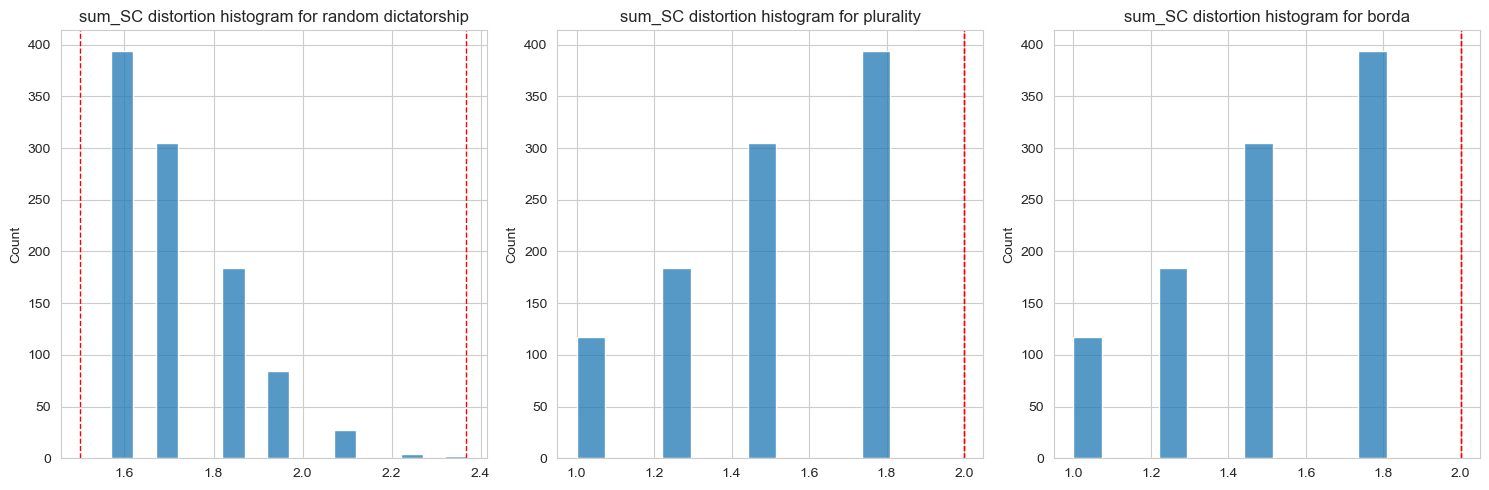

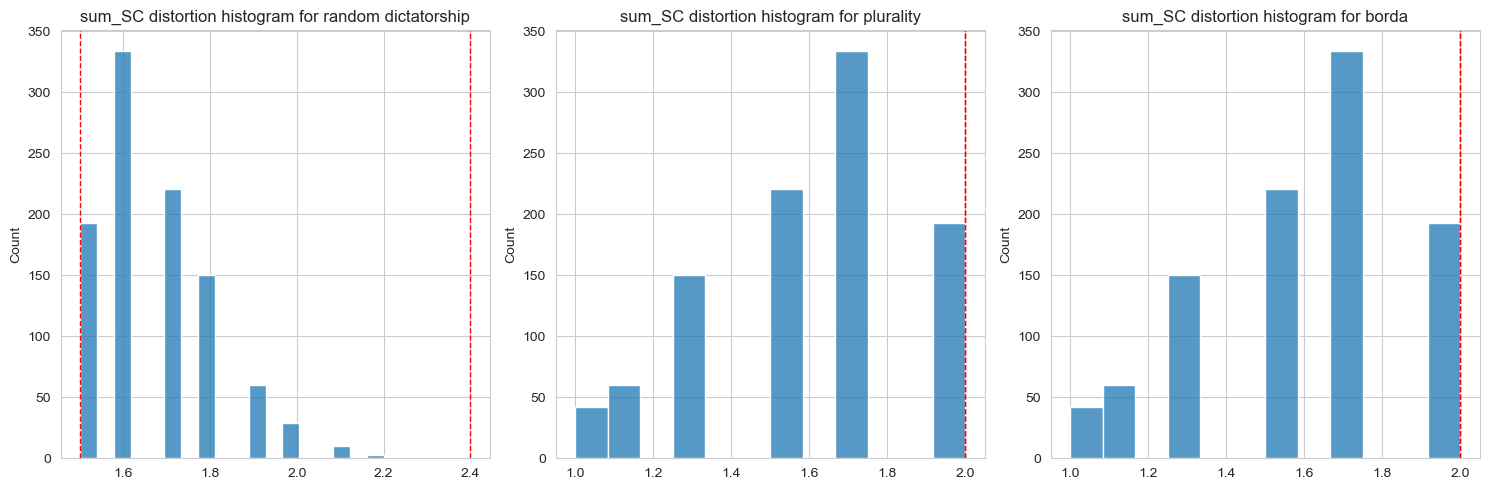

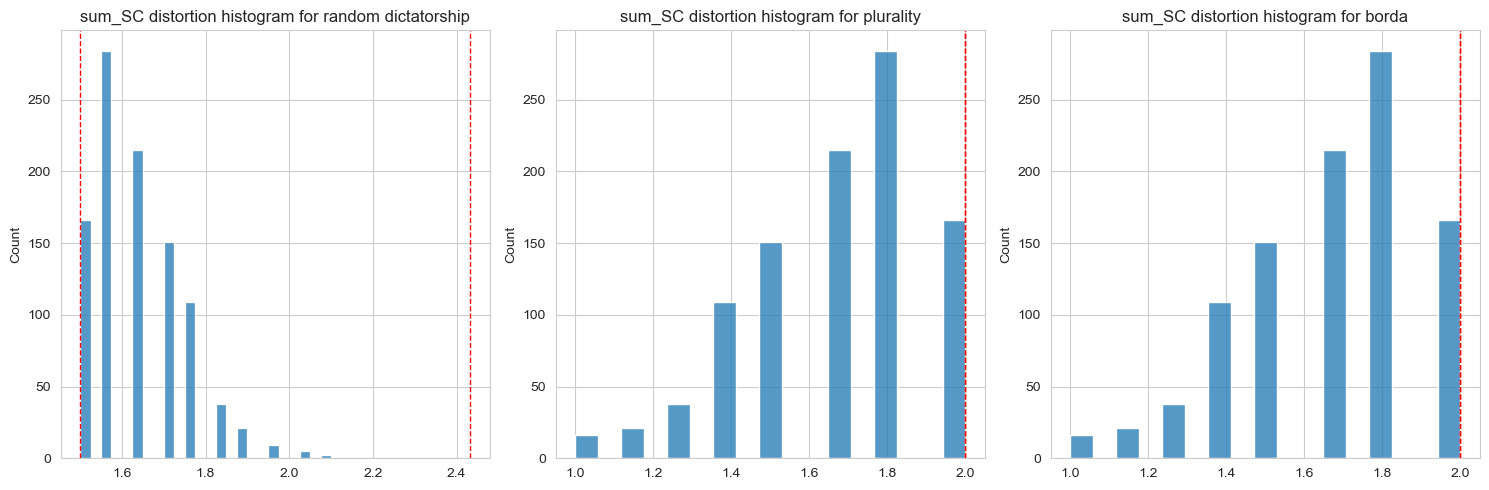

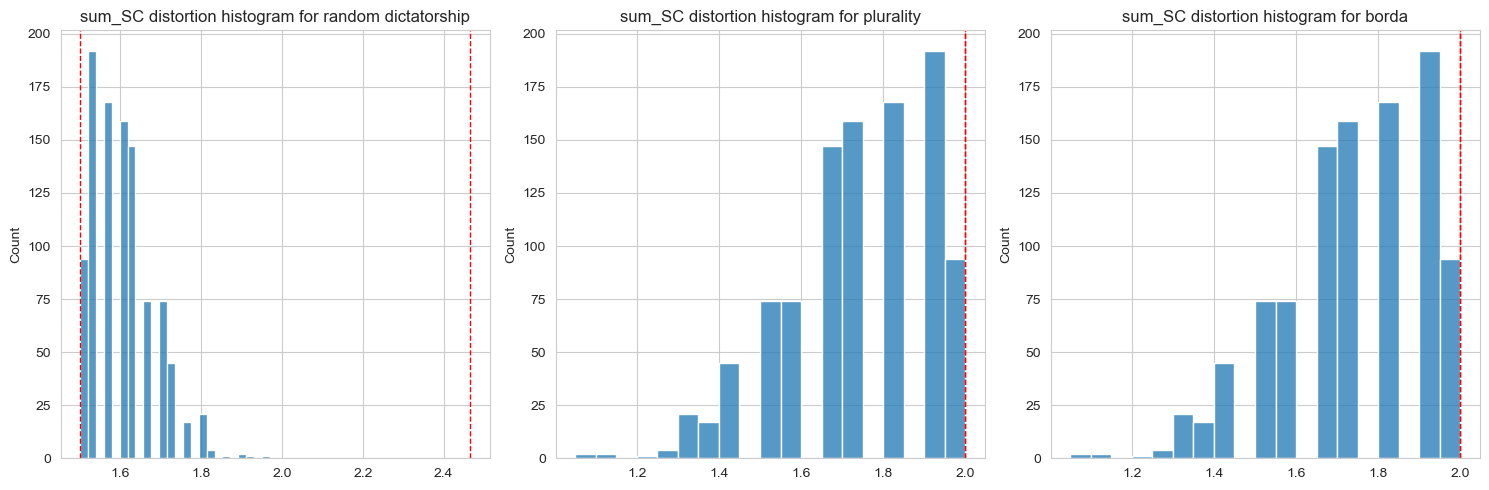

In [33]:
# here we can see that distortion result are robust with the amount of voters
iterations = range(1000)
alpha = 0.5
num_agents = 15
num_candidates = 2
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)
num_agents = 20
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)
num_agents = 30
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)
num_agents = 60
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)

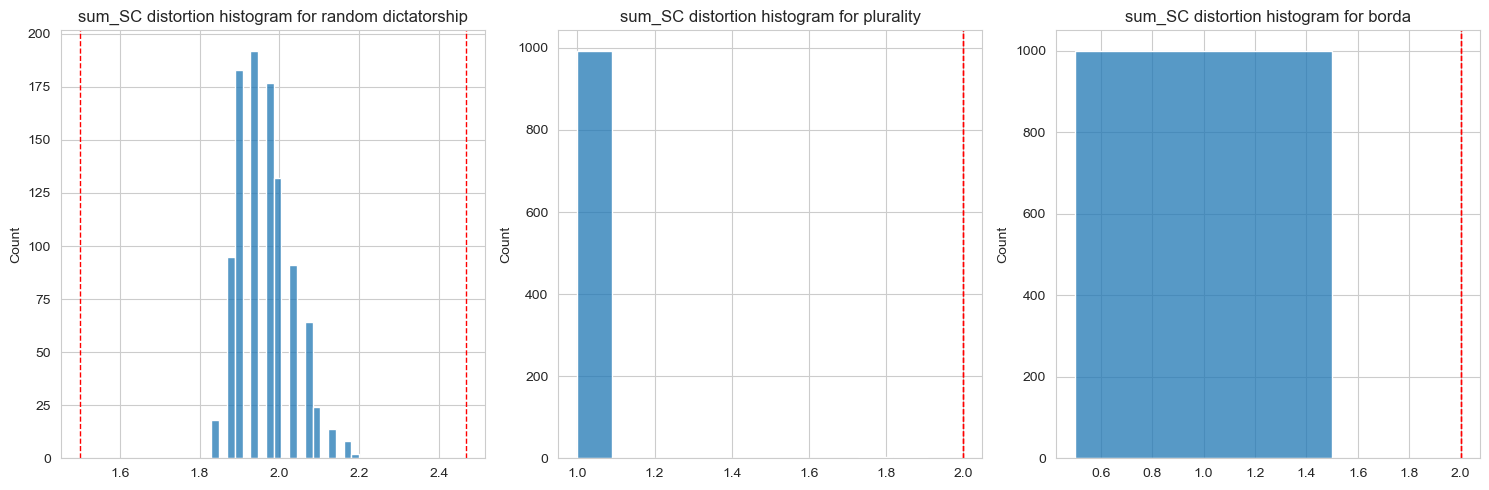

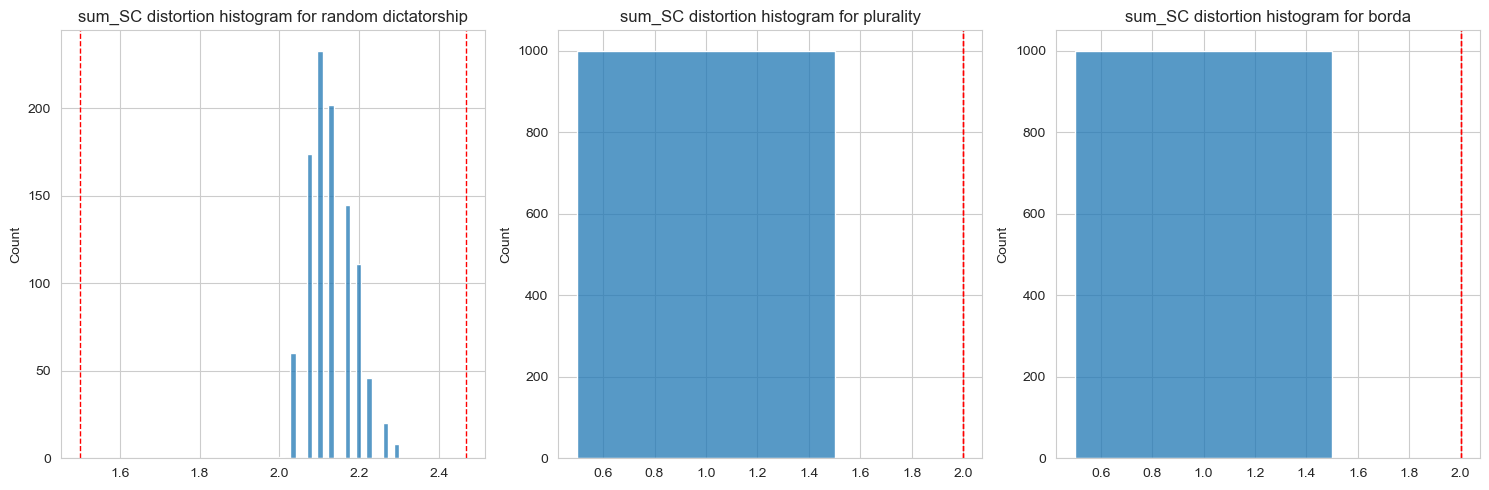

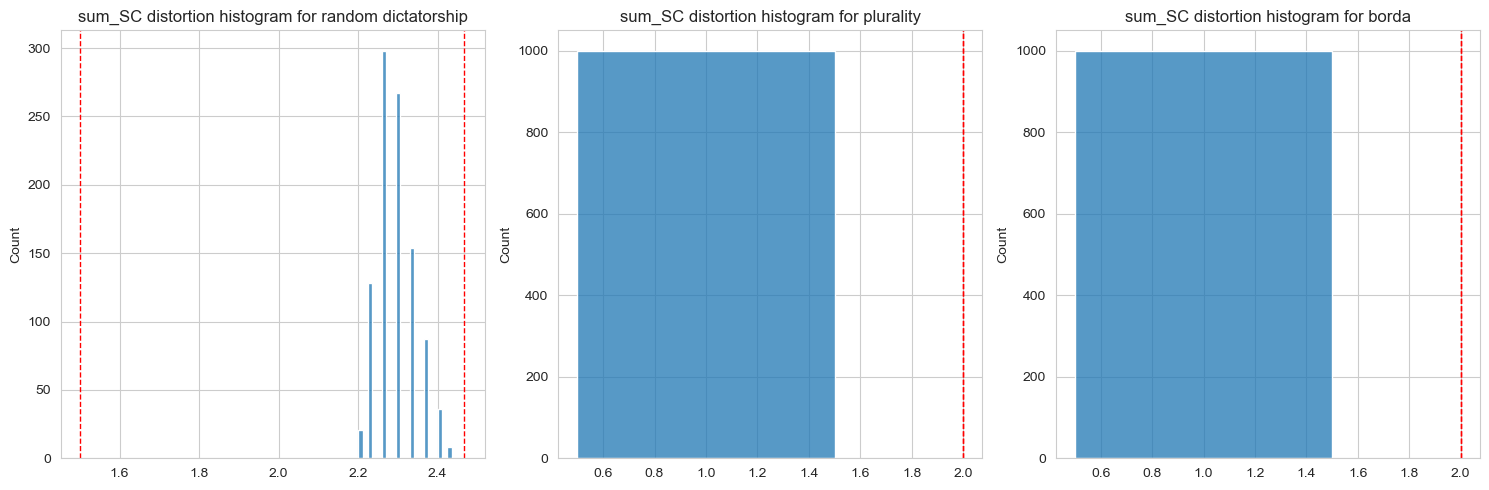

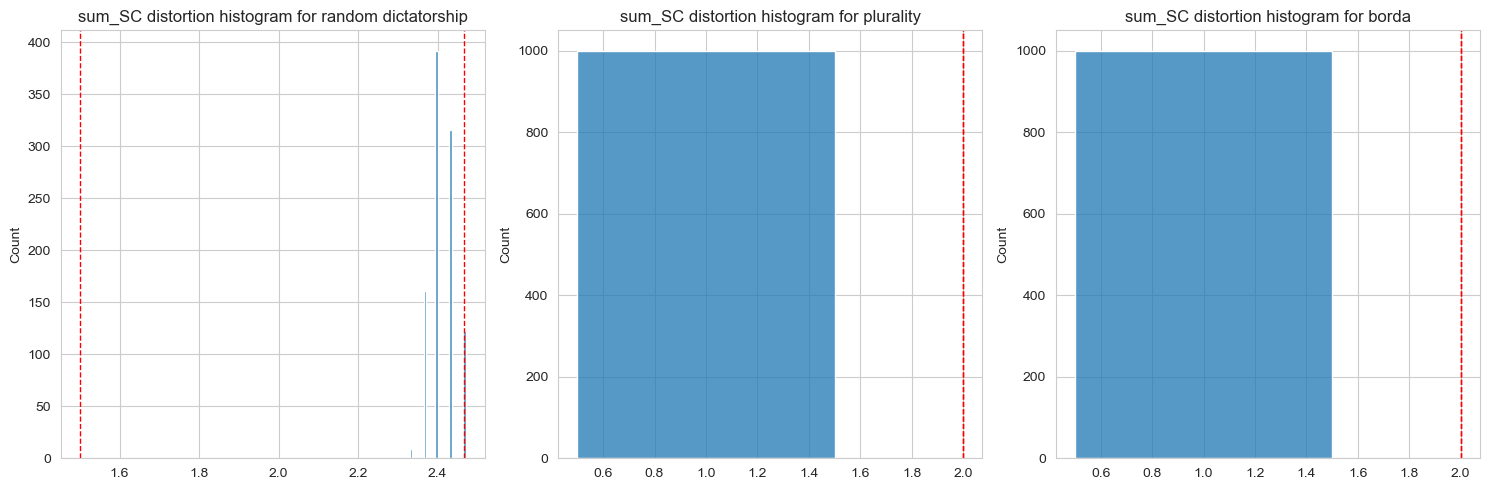

In [34]:
# here we can see that utillity of random-dictatorship rapidly decreases with the number of candidates, almost imidiatly borda start to 
iterations = range(1000)
alpha = 0.5
num_agents = 60
num_candidates = 3
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)
num_candidates = 4
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)
num_candidates = 6
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)
num_candidates = 10
part_2(iterations, alpha, num_agents, num_candidates,no_GPts=True)

# Summary
in this notebook we made available implementation for several social choice functions and objectives as well as distortion calculation function for the sum of agents costs objective. 

also implemented is a skeleton for the optimal randomized mechanism for the $\alpha$-decisive, 1-Euclidean space. 

we show tighter bound for the deterministic social function for $\alpha$-decisive spaces  

we also explored the worst-case distortion for deterministic social choice functions in $\alpha$-decisive elections and how the distortion changes with the number of agents and candidates.

while distortion remains effective for larger voter pool, it quickly becomes useless for larger number of candidates. as both borda and plurality quickly become the optimal choice for the social choice function. 

we met some significant difficulty with the alpha Generalized Proportional to Squares as for some values (such as |Y|=2,|X|=8,alpha=0.5) the result is not a portability, instead we get $p(Y)=\frac{-1}{43}\lt0$ and $p(X)=\frac{44}{43}\gt1$ which are obviously not probabilities. sadly I wasn't able to get to the bottom of this.

this notebook can be used to easily implement more social choice functions and objective and to continue to explore distortion. 

I hope in the near future to implement the optimal randomized mechanism for the $\alpha$-decisive, 1-Euclidean space and to explore the distortion for the median of agents costs objective. and hopefully get to the bottom of the alphaGPtS problem


